# Self Organising Maps

To demonstrate the usage of self organising maps (SOM), in this tutorial we will first implement a self-contained implementation of a general SOM model. We will then apply this model to the classical fashion MNIST dataset

The first exercise involves filling in the four missing lines of code in the *forward* and *self_organizing* functions in our implementation of SOM below. You might find it useful to refer back to the lecture slides where the details of the competition and co-operation process of SOM is outlined.

In [8]:
# Adapted with modification from:
# https://github.com/Dotori-HJ/SelfOrganizingMap-SOM

import torch
import torch.nn as nn
from torchvision.utils import save_image

class SOM(nn.Module):
    def __init__(self, input_size, out_size=(10, 10), lr=0.3, sigma=None):
        '''
        :param input_size:
        :param out_size:
        :param lr:
        :param sigma:
        '''
        super(SOM, self).__init__()
        self.input_size = input_size
        self.out_size = out_size

        self.lr = lr
        if sigma is None:
            self.sigma = max(out_size) / 2
        else:
            self.sigma = float(sigma)

        self.weight = nn.Parameter(torch.randn(input_size, out_size[0] * out_size[1]), requires_grad=False)
        self.locations = nn.Parameter(torch.Tensor(list(self.get_map_index())), requires_grad=False)
        self.pdist_fn = nn.PairwiseDistance(p=2)

    def get_map_index(self):
        '''Two-dimensional mapping function'''
        for x in range(self.out_size[0]):
            for y in range(self.out_size[1]):
                yield (x, y)

    def _neighborhood_fn(self, input, current_sigma):
        '''e^(-(input / sigma^2))'''
        input.div_(current_sigma ** 2)
        input.neg_()
        input.exp_()

        return input

    def forward(self, input):
        '''
        Find the location of best matching unit.
        :param input: data
        :return: location of best matching unit, loss
        '''
        batch_size = input.size()[0]
        input = input.view(batch_size, -1, 1)
        batch_weight = self.weight.expand(batch_size, -1, -1)
        batch_weight_trans = torch.transpose(batch_weight, 1, 2)
        input_trans = torch.transpose(input, 1, 2)

        dists = torch.cdist(batch_weight_trans, input_trans, p=2)
        dists = torch.squeeze(dists)
        

#       dists = self.pdist_fn(input, batch_weight_trans)
        
        # Find best matching unit
        losses, bmu_indexes = dists.min(dim=1, keepdim=True)
        bmu_locations = self.locations[bmu_indexes]

        return bmu_locations, losses.sum().div_(batch_size).item()

    def self_organizing(self, input, current_iter, max_iter):
        '''
        Train the Self Oranizing Map(SOM)
        :param input: training data
        :param current_iter: current epoch of total epoch
        :param max_iter: total epoch
        :return: loss (minimum distance)
        '''
        batch_size = input.size()[0]
        #Set learning rate
        iter_correction = 1.0 - current_iter / max_iter
        lr = self.lr * iter_correction
        sigma = self.sigma * iter_correction

        #Find best matching unit
        bmu_locations, loss = self.forward(input)
        

        distance_squares = self.locations.float() - bmu_locations.float()
        distance_squares.pow_(2)
        distance_squares = torch.sum(distance_squares, dim=2)

        lr_locations = self._neighborhood_fn(distance_squares, sigma)
        lr_locations.mul_(lr).unsqueeze_(1)

        delta = lr_locations * (input.unsqueeze(2) - self.weight)
        delta = delta.sum(dim=0)
        delta.div_(batch_size)
        self.weight.data.add_(delta)

        return loss

    def save_result(self, dir, im_size=(0, 0, 0)):
        '''
        Visualizes the weight of the Self Oranizing Map(SOM)
        :param dir: directory to save
        :param im_size: (channels, size x, size y)
        :return:
        '''
        images = self.weight.view(im_size[0], im_size[1], im_size[2], self.out_size[0] * self.out_size[1])

        images = images.permute(3, 0, 1, 2)
        save_image(images, dir, normalize=True, padding=1, nrow=self.out_size[0])

Now let's apply our above model to the fashion MNIST dataset

In [9]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
import os
import time
import torch
import argparse
import matplotlib.pyplot as plt

In [10]:
batch_size = 32
total_epoch = 100
row = 20
col = 20
transform = transforms.Compose( [transforms.ToTensor()])

In [11]:
train_data = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [12]:
train_data.data = train_data.train_data[:5000]
train_data.targets = train_data.train_labels[:5000]

In [13]:
device = torch.device('cpu')
som = SOM(input_size=28 * 28 * 1, out_size=(row, col))
som = som.to(device)

In [ ]:
losses = list()
for epoch in range(total_epoch):
    running_loss = 0
    start_time = time.time()
    for idx, (X, Y) in enumerate(train_loader):
        X = X.view(-1, 28 * 28 * 1).to(device)    # flatten
        loss = som.self_organizing(X, epoch, total_epoch)    # train som
        running_loss += loss

        losses.append(running_loss)
        print('epoch = %d, loss = %.2f, time = %.2fs' % (epoch + 1, running_loss, time.time() - start_time))


plt.title('SOM loss')
plt.plot(losses)
plt.show()

In [35]:
som.save_result('./som_result.png', (1, 28, 28))
torch.save(som.state_dict(), './som.pth')

<img src="som_result.png">

# Support Vector Machines

In this section we will implement a SVM model for the classical iris dataset. We will be utilising the svm feature from the sklearn library.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
colnames=["sepal_length_in_cm", "sepal_width_in_cm","petal_length_in_cm","petal_width_in_cm", "class"]

#Read the dataset
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header = None, names= colnames )

#Data
dataset.head()

,sepal_length_in_cm,sepal_width_in_cm,petal_length_in_cm,petal_width_in_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [39]:
#Encoding the categorical column
dataset = dataset.replace({"class":  {"Iris-setosa":1,"Iris-versicolor":2, "Iris-virginica":3}})
#Visualize the new dataset
dataset.head()

,sepal_length_in_cm,sepal_width_in_cm,petal_length_in_cm,petal_width_in_cm,class
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


Text(0.5, 1.0, 'Correlation On iris Classes')

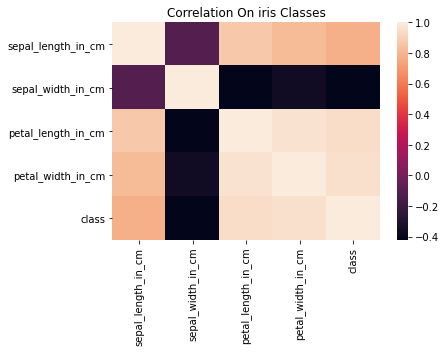

In [40]:
plt.figure(1)
sns.heatmap(dataset.corr())
plt.title('Correlation On iris Classes')

In [42]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [43]:
#Create the SVM model
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
#Fit the model for the data

classifier.fit(X_train, y_train)

#Make the prediction
y_pred = classifier.predict(X_test)

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]
Accuracy: 98.18 %
Standard Deviation: 3.64 %


## Exercise
1) Write a paragraph providing some critical analysis of your findings from the SOM analysis of the FashionMNIST data. Look to use the theory from last week's lecture to help inform the insight that your provide into your findings.

2) Change some of the parameter settings for the Support Vector Classifier (SVC) defined in the lab. Consider changing the type of kernel function used, altering the Regularisation parameter C, altering the Kernel coefficient gamma for example.

3) Summarise your findings from changing the hyperparameter settings for your SVC.